<a href="https://colab.research.google.com/github/tanzeel641/Melanoma-Skin-Cancer-Detection/blob/main/skin_cancer_model_h5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

skin cancer classification ResNet50

1. تحميل مكتبات Kaggle ورفع kaggle.jso

In [ ]:
!pip install -q kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'


## 📂 الخطوة 2: تحميل بيانات HAM10000 من Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

import zipfile
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/skin-cancer")


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
^C


In [ ]:
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

base_dir = '/content/skin-cancer'
img_dir = os.path.join(base_dir, 'HAM10000_images_part_1')
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')

df = pd.read_csv(metadata_path)
df = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(img_dir, x + '.jpg')))]

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = df['dx'].unique()

for cls in classes:
    cls_df = df[df['dx'] == cls]
    train_split, val_split = train_test_split(cls_df, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for _, row in train_split.iterrows():
        src = os.path.join(img_dir, row['image_id'] + '.jpg')
        dst = os.path.join(train_dir, cls, row['image_id'] + '.jpg')
        shutil.copyfile(src, dst)

    for _, row in val_split.iterrows():
        src = os.path.join(img_dir, row['image_id'] + '.jpg')
        dst = os.path.join(val_dir, cls, row['image_id'] + '.jpg')
        shutil.copyfile(src, dst)

print("✅ تم التقسيم إلى مجلدات train و val.")


✅ تم التقسيم إلى مجلدات train و val.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/skin-cancer/train'
val_path = '/content/skin-cancer/val'

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3997 images belonging to 7 classes.
Found 1003 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# تجميد طبقات ResNet
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 732ms/step - accuracy: 0.6447 - loss: 1.2114 - val_accuracy: 0.6849 - val_loss: 1.1240
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.6826 - loss: 1.1123 - val_accuracy: 0.6849 - val_loss: 1.1081
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step - accuracy: 0.6945 - loss: 1.0918 - val_accuracy: 0.6849 - val_loss: 1.1077
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.6905 - loss: 1.0928 - val_accuracy: 0.6849 - val_loss: 1.0940
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.6872 - loss: 1.1057 - val_accuracy: 0.6859 - val_loss: 1.0887


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import math

steps = math.ceil(val_gen.samples / val_gen.batch_size)

y_probs = model.predict(val_gen, steps=steps, verbose=1)
y_pred = np.argmax(y_probs, axis=1)
y_true = val_gen.classes[:len(y_pred)]
class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        37
         bcc       0.00      0.00      0.00        54
         bkl       0.00      0.00      0.00       113
          df       0.00      0.00      0.00        12
         mel       1.00      0.01      0.02        87
          nv       0.69      1.00      0.81       687
        vasc       0.00      0.00      0.00        13

    accuracy                           0.69      1003
   macro avg       0.24      0.14      0.12      1003
weighted avg       0.56      0.69      0.56      1003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


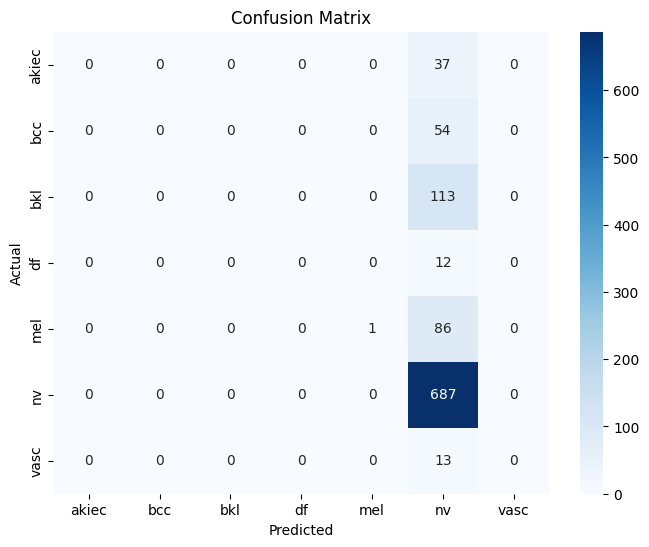

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_names = list(val_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
model.save('/content/skin_cancer_model.h5')


NameError: name 'model' is not defined

In [ ]:
!pip install -q gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# تحميل النموذج
model = tf.keras.models.load_model('/content/skin_cancer_model.h5')

# أسماء الفئات حسب المولد
class_names = list(train_gen.class_indices.keys())

# دالة التنبؤ الكاملة
def predict_skin_cancer(img):
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)[0]
    top_3_indices = np.argsort(preds)[-3:][::-1]
    top_3 = {class_names[i]: float(preds[i]) for i in top_3_indices}

    predicted_class = class_names[np.argmax(preds)]

    result = f"🧠 **Predicted Class:** {predicted_class}\n\n"
    result += "**Top 3 Probabilities:**\n"
    for cls, prob in top_3.items():
        result += f"- {cls}: {prob:.4f}\n"

    return result

# Gradio interface
interface = gr.Interface(
    fn=predict_skin_cancer,
    inputs=gr.Image(type="pil", label="Upload Dermoscopic Image"),
    outputs=gr.Markdown(),
    title="🔬 Skin Cancer Classification using CNN + Transfer Learning",
    description=(
        "Upload a dermoscopic skin lesion image. "
        "This model uses a ResNet50-based CNN trained on the HAM10000 dataset to predict the type of skin cancer. "
        "Built using TensorFlow and deployed via Gradio."
    ),
    examples=None
)

interface.launch(share=True)  # `share=True` ينشئ رابط خارجي لو حابة تعرضيه للمشرف أو بالعرض النهائي


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/skin_cancer_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)